In [5]:
import numpy as np
from ecgdetectors import Detectors
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def normalize(signal: np.ndarray) -> np.ndarray:
    """Normalize signal to [0,1] handling NaNs gracefully."""
    s = np.asarray(signal, dtype=float)
    if s.size == 0:
        return s
    # Use nan-aware min/max to avoid propagating NaNs
    s_min = np.nanmin(s)
    s_max = np.nanmax(s)
    denom = (s_max - s_min)
    if not np.isfinite(denom) or denom == 0:
        # Flat or invalid; return zeros
        return np.nan_to_num(s - s_min)
    return np.nan_to_num((s - s_min) / denom)

def find_r_peaks(ecg_signal: np.ndarray, fs: int = 300):
    """Find R-peaks using Engzee detector with fixed fs=300 Hz.
    ecg_signal should be a 1-D array (single lead). Returns sample indices.
    """
    sig = np.asarray(ecg_signal, dtype=float)
    if sig.ndim != 1:
        sig = sig.ravel()
    sig = normalize(sig)
    detectors = Detectors(fs)
    try:
        r = detectors.engzee_detector(sig)
    except Exception as e:
        # Fallback: return empty list if detector fails
        r = []
    return np.array(r, dtype=int)

def segment_data(ecg_signal, r_peaks, segment_length=225, pre_r=78, post_r=147):
    return [
        np.array([normalize(ecg_signal[start:end, j]) for j in range(ecg_signal.shape[1])]).T
        for start, end in [(r - pre_r, r + post_r) for r in r_peaks]
        if 0 <= start < len(ecg_signal) and end <= len(ecg_signal)
    ]

# Reconvert values in predictions to binary for each segment
def reconvert_and_inverse_transform(delineados):
    return [
        encoder.inverse_transform(np.array([np.where(segment[i] == np.max(segment[i]), 1, 0) for i in range(segment.shape[0])]))
        for segment in delineados
    ]

# Retrieve P and T points based on segmented labels
def get_P_and_T_points(segmentos_delineados, r_peaks, pre_r=78):
    P_points, T_points = [], []
    for i, seg in enumerate(segmentos_delineados):
        start = r_peaks[i] - pre_r
        P_points.append(np.where(seg == 'P')[0][0] + start)
        T_points.append(np.where(seg == 'R')[0][-1] + start)
    return P_points, T_points

In [3]:
model = tf.keras.models.load_model('/home/david/Documents/ECG_delineation/Delineation_ECG/delineador_ECG/model.keras')
# Prepare encoder no matter what (labels used downstream if model ok)
encoder = OneHotEncoder(sparse_output=False)
encoder.fit([['N'], ['P'], ['R']])
detectors = Detectors(300)
ecg = []
with open('/home/david/Documents/ECG_delineation/ecg-sanos/wetransfer_ecgs_2024-09-09_1340/ecg-julia/Estudio.vak', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ecg.append([x for x in line.split()])

ecg_x = np.asarray([np.float32(x[0]) for x in ecg[1:]], dtype=np.float32)
# convert ecg to 2D array with shape (n_samples, n_leads) n_leads=12, excluding first column
ecg = np.asarray([[np.float32(x[i]) for i in range(1, 13)] for x in ecg[1:]], dtype=np.float32)
ecg_2 = ecg[:, 1]  # Use II lead for R-peak detection and segmentation
lead_sig = normalize(ecg_2)
r_peaks_arr = detectors.engzee_detector(lead_sig)
r_peaks = np.asarray(r_peaks_arr, dtype=int)

P_points, T_points = [], []
segments_list = segment_data(ecg, r_peaks)
segments_array = np.asarray(segments_list)
delineados = model.predict(segments_array, verbose=0)
segmentos_delineados = reconvert_and_inverse_transform(delineados)
P_points, T_points = get_P_and_T_points(segmentos_delineados, r_peaks)


E0000 00:00:1759521061.250353  156165 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759521061.258423  156165 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
#T_points = np.array(T_points, dtype=int)
x = np.arange(len(ecg_2))

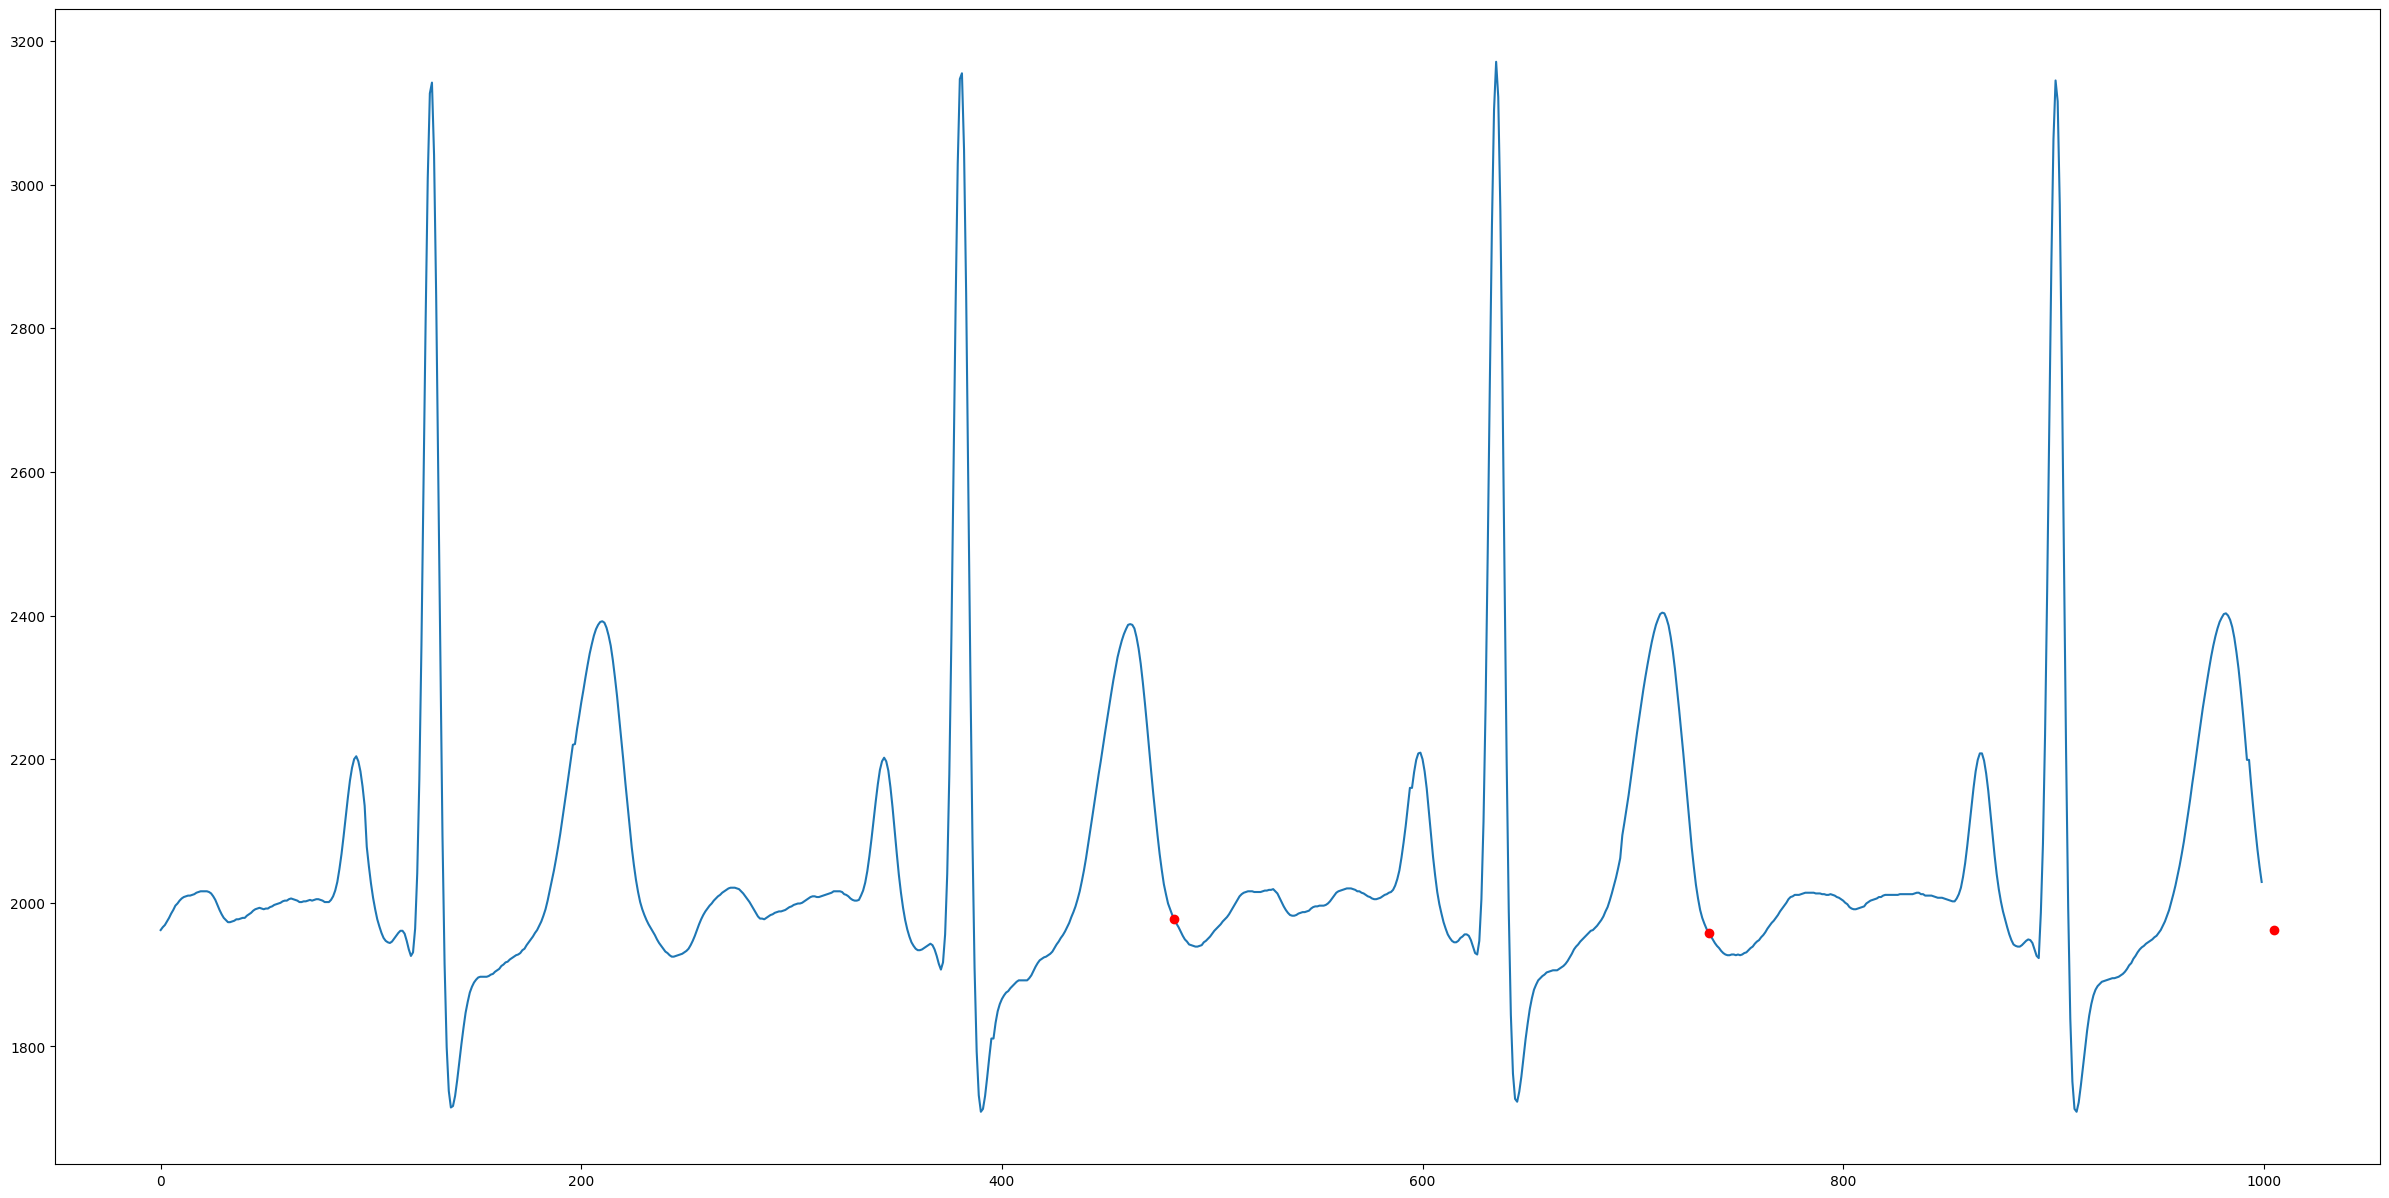

In [12]:
plt.figure(figsize=(30,15))
plt.plot(ecg_2[:1000])
plt.plot(x[T_points[:3]], ecg_2[T_points[:3]], 'ro')
plt.show()